# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_LAUNCH_BLOCKING"]="0"

In [2]:
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from numpy.ma import masked_where

/home/srirampingali/anaconda3/envs/BTP/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Import Data

In [4]:
items = pd.read_csv("../Datasets/ml-100k/Text/items.csv")

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../Datasets/ml-100k/Text/u1.base', sep='\t', names=r_cols,encoding='latin-1')

In [5]:
n_users = 943
n_items = 1682

In [6]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [7]:
data_matrix_emp = data_matrix.copy()
data_matrix_emp[data_matrix < 4] = 0
data_matrix_emp[data_matrix >= 4]= 1 

In [8]:
train_indices = list(zip(*(np.where(data_matrix != 0))))

# Siamese network

## Data loader

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.__version__

'1.13.1+cu117'

In [12]:
items_csv = "../Datasets/ml-100k/Text/items.csv"
train_ratings = "../Datasets/ml-100k/Text/u1.base"
test_ratings = "../Datasets/ml-100k/Text/u1.test"

item_path = "../Datasets/ml-100k/"
ROW = 30
BATCH = 2000

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class MovielensDataset(Dataset):
    def __init__(self, ratings = train_ratings, item_path = item_path, device = device):
        self.item_path = item_path
        self.video_embeddings = pd.read_csv(item_path + "Video/embeddings.csv").to_numpy()
        self.audio_embeddings = pd.read_csv(item_path + "Audio/embeddings.csv").to_numpy()
        self.meta_embeddings = pd.read_csv(item_path + "Meta/embeddings.csv").to_numpy()
        self.text_embeddings = pd.read_csv(item_path + "Text/embeddings.csv").to_numpy()
        self.ratings = pd.read_csv(ratings, sep='\t', 
                                   names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1')
        self.indices = None
        self.device = device
        self.data = None
        self.n_users = None
        self.n_items = None
        self.fill_ratings()
        self.embeddings()
    
    def fill_ratings(self, threshold=4):
        self.n_users = self.ratings.user_id.unique().shape[0]
        self.n_items = self.ratings.movie_id.unique().shape[0]
        
        self.data = np.zeros((n_users, n_items))
        for line in self.ratings.itertuples():
            self.data[line[1]-1, line[2]-1] = line[3]
        
        self.data_emp = np.where(np.logical_and(self.data > 3,
                            np.random.random_sample(self.data.shape) <= 0.2), 1, 0)
        self.indices = list(zip(*(np.where(self.data != 0))))
        
    def embeddings(self):
        print(self.video_embeddings.shape)
        self.audio_embeddings = normalize(self.audio_embeddings, axis = 0)
        self.video_embeddings = normalize(self.video_embeddings, axis = 0)
        self.user_embeddings = np.divide(np.dot(self.data_emp, self.meta_embeddings), 
                                         self.data_emp.sum(axis = 1)[:, None] + 0.001)
#         self.user_embeddings = data_matrix
        self.item_embeddings = data_matrix.T
        self.video_embedding_size = self.video_embeddings.shape[1]
        self.audio_embedding_size = self.audio_embeddings.shape[1]
        self.text_embedding_size = self.text_embeddings.shape[1]
        self.user_embedding_size = self.user_embeddings.shape[1]
        self.item_embedding_size = self.item_embeddings.shape[1]
        self.meta_embedding_size = self.meta_embeddings.shape[1]
        
    def __len__(self):
        return(len(self.indices))
    
    def __getitem__(self, idx):
        user = self.indices[idx][0]
        item = self.indices[idx][1]
        
#         xu = self.user_embeddings(torch.LongTensor([user])).squeeze().to(self.device)
        xu = torch.from_numpy(self.user_embeddings[user]).to(self.device)
        xa = torch.from_numpy(self.audio_embeddings[item]).to(self.device)
        xv = torch.from_numpy(self.video_embeddings[item]).to(self.device)
        xt = torch.from_numpy(self.text_embeddings[item]).to(self.device)
        xi = torch.from_numpy(self.item_embeddings[item]).to(self.device)
        xm = torch.from_numpy(self.meta_embeddings[item]).to(self.device)
        
        y = self.data[user][item]
        return(xu.float(), [xv.float(), xa.float(), xt.float(), xi.float(), xm.float()], int(y))

In [15]:
train_dataset = MovielensDataset(ratings = train_ratings)
test_dataset = MovielensDataset(ratings = test_ratings)

(1682, 1024)
(1682, 1024)


In [16]:
trainloader = DataLoader(train_dataset, batch_size = BATCH, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = BATCH, shuffle = False)

## Architecture

In [18]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict

In [19]:
# from ml_metrics import mapk
# from recmetrics import mark

In [20]:
weight = np.array([np.count_nonzero(train_dataset.data == i) for i in range(1, 6)])
weight = weight.max() / weight
weight = torch.Tensor(weight).to(device)

In [21]:
def weighted_mse_loss(pred, target, weight=weight):
    target = target.long()
    weight = weight[target - 1].to(pred.dtype)
    loss = (pred - target.to(pred.dtype)).pow(2)
    return ((weight * loss).mean(), loss.mean())

In [22]:
class SiameseNet(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))
        
        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))
        
        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))
        
        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))
        
        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))
        
        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)
            
    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)
        
    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)
        
        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)
        
        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)
        
        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)
        
        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_t, v_a)
        imv = self.exp(q_v, k_m, v_v)
        itm = self.exp(q_m, k_t, v_m)
        
        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)
    
    def fit(self, trainloader = trainloader, 
            testloader = testloader, epochs = 100):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)
        
        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0
            
            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2 
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i, 
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)
            
    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))
            
            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [23]:
sm_net = SiameseNet()
sm_net.to(device)

SiameseNet(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=1024, out_features=600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=600, out_features=300, bias=True)
    (relu4):

In [24]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:20,  1.94it/s]


tensor([[1.5956],
        [2.7136],
        [1.5956],
        ...,
        [1.6860],
        [2.8690],
        [2.6537]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      1.00      0.61       865
           1       1.00      0.01      0.01      1135

    accuracy                           0.44      2000
   macro avg       0.72      0.50      0.31      2000
weighted avg       0.76      0.44      0.27      2000

Epoch-1: Loss = 7.350
Train RMSE = 1.951||Train Precision = 83.333||Train Recall = 0.465
Test RMSE = 1.549 || Test Precision = 100.000|| Test Recall = 0.529


40it [00:20,  2.00it/s]


tensor([[2.2138],
        [3.0360],
        [2.2138],
        ...,
        [2.3245],
        [3.1502],
        [2.8408]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.86      0.59       865
           1       0.63      0.17      0.27      1135

    accuracy                           0.47      2000
   macro avg       0.54      0.52      0.43      2000
weighted avg       0.55      0.47      0.41      2000

Epoch-2: Loss = 4.043
Train RMSE = 1.321||Train Precision = 78.472||Train Recall = 10.180
Test RMSE = 1.372 || Test Precision = 62.857|| Test Recall = 17.445


40it [00:19,  2.01it/s]


tensor([[2.3965],
        [3.1351],
        [2.3965],
        ...,
        [2.4304],
        [3.1768],
        [2.7001]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.47      0.85      0.60       865
           1       0.70      0.27      0.38      1135

    accuracy                           0.52      2000
   macro avg       0.58      0.56      0.49      2000
weighted avg       0.60      0.52      0.48      2000

Epoch-3: Loss = 3.649
Train RMSE = 1.238||Train Precision = 79.336||Train Recall = 19.060
Test RMSE = 1.326 || Test Precision = 69.676|| Test Recall = 26.520


40it [00:20,  1.93it/s]


tensor([[2.5916],
        [3.2604],
        [2.5918],
        ...,
        [2.4739],
        [3.1511],
        [2.4628]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.83      0.61       865
           1       0.72      0.34      0.46      1135

    accuracy                           0.55      2000
   macro avg       0.61      0.58      0.54      2000
weighted avg       0.62      0.55      0.53      2000

Epoch-4: Loss = 3.348
Train RMSE = 1.181||Train Precision = 76.562||Train Recall = 26.703
Test RMSE = 1.293 || Test Precision = 72.180|| Test Recall = 33.833


40it [00:21,  1.90it/s]


tensor([[2.8393],
        [3.4132],
        [2.8396],
        ...,
        [2.6163],
        [3.0950],
        [2.3736]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.78      0.62       865
           1       0.72      0.44      0.54      1135

    accuracy                           0.58      2000
   macro avg       0.62      0.61      0.58      2000
weighted avg       0.63      0.58      0.57      2000

Epoch-5: Loss = 3.089
Train RMSE = 1.138||Train Precision = 79.562||Train Recall = 39.315
Test RMSE = 1.250 || Test Precision = 71.843|| Test Recall = 43.612


40it [00:20,  1.97it/s]


tensor([[3.0059],
        [3.4508],
        [3.0066],
        ...,
        [2.7488],
        [3.1403],
        [2.4371]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.74      0.60       865
           1       0.70      0.47      0.56      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.62      0.58      0.58      2000

Epoch-6: Loss = 2.881
Train RMSE = 1.103||Train Precision = 75.542||Train Recall = 45.227
Test RMSE = 1.232 || Test Precision = 69.960|| Test Recall = 46.784


40it [00:20,  1.99it/s]


tensor([[3.0940],
        [3.4964],
        [3.0949],
        ...,
        [2.8252],
        [3.1452],
        [2.5168]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       865
           1       0.69      0.50      0.58      1135

    accuracy                           0.59      2000
   macro avg       0.60      0.60      0.59      2000
weighted avg       0.61      0.59      0.58      2000

Epoch-7: Loss = 2.745
Train RMSE = 1.081||Train Precision = 74.403||Train Recall = 52.825
Test RMSE = 1.224 || Test Precision = 68.742|| Test Recall = 49.604


40it [00:20,  1.97it/s]


tensor([[3.1926],
        [3.5134],
        [3.1936],
        ...,
        [2.8812],
        [3.1252],
        [2.4338]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.68      0.59       865
           1       0.69      0.54      0.60      1135

    accuracy                           0.60      2000
   macro avg       0.61      0.61      0.60      2000
weighted avg       0.62      0.60      0.60      2000

Epoch-8: Loss = 2.658
Train RMSE = 1.069||Train Precision = 73.908||Train Recall = 53.769
Test RMSE = 1.220 || Test Precision = 68.729|| Test Recall = 53.833


40it [00:21,  1.86it/s]


tensor([[3.1982],
        [3.3818],
        [3.1998],
        ...,
        [2.9029],
        [3.0128],
        [2.5647]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.71      0.60       865
           1       0.69      0.50      0.58      1135

    accuracy                           0.59      2000
   macro avg       0.61      0.60      0.59      2000
weighted avg       0.62      0.59      0.59      2000

Epoch-9: Loss = 2.615
Train RMSE = 1.063||Train Precision = 78.100||Train Recall = 52.622
Test RMSE = 1.229 || Test Precision = 69.250|| Test Recall = 49.604


40it [00:21,  1.85it/s]


tensor([[3.1931],
        [3.3514],
        [3.1973],
        ...,
        [2.9382],
        [3.0193],
        [2.6722]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.71      0.60       865
           1       0.70      0.51      0.59      1135

    accuracy                           0.60      2000
   macro avg       0.61      0.61      0.60      2000
weighted avg       0.62      0.60      0.60      2000

Epoch-10: Loss = 2.561
Train RMSE = 1.055||Train Precision = 77.891||Train Recall = 54.781
Test RMSE = 1.218 || Test Precision = 69.690|| Test Recall = 51.454


40it [00:20,  1.94it/s]


tensor([[3.1704],
        [3.2941],
        [3.1902],
        ...,
        [2.8432],
        [2.8998],
        [2.4956]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.77      0.61       865
           1       0.71      0.42      0.53      1135

    accuracy                           0.57      2000
   macro avg       0.60      0.60      0.57      2000
weighted avg       0.62      0.57      0.56      2000

Epoch-11: Loss = 2.544
Train RMSE = 1.053||Train Precision = 80.873||Train Recall = 49.493
Test RMSE = 1.231 || Test Precision = 70.623|| Test Recall = 41.938


40it [00:20,  1.91it/s]


tensor([[3.3560],
        [3.5087],
        [3.4592],
        ...,
        [3.1698],
        [3.0654],
        [2.5907]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       865
           1       0.69      0.55      0.62      1135

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.63      0.61      0.61      2000

Epoch-12: Loss = 2.499
Train RMSE = 1.046||Train Precision = 78.548||Train Recall = 63.864
Test RMSE = 1.216 || Test Precision = 69.469|| Test Recall = 55.330


40it [00:21,  1.89it/s]


tensor([[2.9647],
        [3.1629],
        [3.3054],
        ...,
        [3.0482],
        [2.8975],
        [2.5402]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.77      0.61       865
           1       0.71      0.43      0.53      1135

    accuracy                           0.57      2000
   macro avg       0.61      0.60      0.57      2000
weighted avg       0.62      0.57      0.57      2000

Epoch-13: Loss = 2.475
Train RMSE = 1.041||Train Precision = 79.943||Train Recall = 50.498
Test RMSE = 1.241 || Test Precision = 70.622|| Test Recall = 42.996


40it [00:23,  1.70it/s]


tensor([[3.2415],
        [3.3551],
        [3.4970],
        ...,
        [3.2441],
        [2.9551],
        [2.5820]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       865
           1       0.71      0.51      0.59      1135

    accuracy                           0.60      2000
   macro avg       0.62      0.62      0.60      2000
weighted avg       0.63      0.60      0.60      2000

Epoch-14: Loss = 2.458
Train RMSE = 1.041||Train Precision = 77.255||Train Recall = 56.037
Test RMSE = 1.206 || Test Precision = 70.818|| Test Recall = 51.101


40it [00:21,  1.89it/s]


tensor([[3.0220],
        [3.3015],
        [3.5210],
        ...,
        [3.2272],
        [2.9315],
        [2.5255]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       865
           1       0.70      0.52      0.59      1135

    accuracy                           0.60      2000
   macro avg       0.62      0.61      0.60      2000
weighted avg       0.63      0.60      0.60      2000

Epoch-15: Loss = 2.445
Train RMSE = 1.037||Train Precision = 79.106||Train Recall = 57.557
Test RMSE = 1.214 || Test Precision = 70.312|| Test Recall = 51.542


40it [00:21,  1.86it/s]


tensor([[3.0084],
        [3.2972],
        [3.5398],
        ...,
        [3.3029],
        [3.0000],
        [2.5555]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.72      0.62       865
           1       0.71      0.52      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-16: Loss = 2.428
Train RMSE = 1.035||Train Precision = 78.748||Train Recall = 53.737
Test RMSE = 1.203 || Test Precision = 71.239|| Test Recall = 52.159


40it [00:20,  1.94it/s]


tensor([[3.3252],
        [3.3622],
        [3.6454],
        ...,
        [3.3421],
        [3.0680],
        [2.6347]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       865
           1       0.71      0.55      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-17: Loss = 2.423
Train RMSE = 1.035||Train Precision = 79.361||Train Recall = 61.053
Test RMSE = 1.204 || Test Precision = 70.833|| Test Recall = 55.419


40it [00:20,  1.93it/s]


tensor([[2.8217],
        [3.0945],
        [3.4919],
        ...,
        [3.3256],
        [2.9002],
        [2.4194]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       865
           1       0.71      0.46      0.56      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.63      0.59      0.58      2000

Epoch-18: Loss = 2.417
Train RMSE = 1.034||Train Precision = 79.358||Train Recall = 51.680
Test RMSE = 1.222 || Test Precision = 71.429|| Test Recall = 46.256


40it [00:20,  1.92it/s]


tensor([[2.7610],
        [3.2381],
        [3.6533],
        ...,
        [3.3449],
        [2.9384],
        [2.4969]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       865
           1       0.72      0.50      0.59      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.62      0.61      2000
weighted avg       0.64      0.61      0.60      2000

Epoch-19: Loss = 2.404
Train RMSE = 1.034||Train Precision = 81.603||Train Recall = 55.200
Test RMSE = 1.207 || Test Precision = 72.401|| Test Recall = 49.692


40it [00:20,  1.91it/s]


tensor([[3.2329],
        [3.3034],
        [3.7045],
        ...,
        [3.4748],
        [3.0666],
        [2.5374]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       865
           1       0.71      0.57      0.63      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-20: Loss = 2.402
Train RMSE = 1.033||Train Precision = 79.200||Train Recall = 61.986
Test RMSE = 1.204 || Test Precision = 70.504|| Test Recall = 56.652


40it [00:20,  1.96it/s]


tensor([[2.8721],
        [3.3233],
        [3.6945],
        ...,
        [3.4249],
        [3.0203],
        [2.5574]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       865
           1       0.72      0.55      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-21: Loss = 2.395
Train RMSE = 1.033||Train Precision = 80.751||Train Recall = 58.870
Test RMSE = 1.190 || Test Precision = 71.824|| Test Recall = 54.802


40it [00:21,  1.87it/s]


tensor([[2.9393],
        [3.1966],
        [3.6754],
        ...,
        [3.4929],
        [2.9873],
        [2.6350]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.73      0.62       865
           1       0.71      0.51      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.63      0.61      0.61      2000

Epoch-22: Loss = 2.389
Train RMSE = 1.029||Train Precision = 78.479||Train Recall = 54.964
Test RMSE = 1.200 || Test Precision = 71.220|| Test Recall = 51.454


40it [00:22,  1.79it/s]


tensor([[2.7705],
        [3.2558],
        [3.7498],
        ...,
        [3.4042],
        [2.9421],
        [2.5224]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.74      0.62       865
           1       0.72      0.51      0.59      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.62      0.61      2000
weighted avg       0.64      0.61      0.60      2000

Epoch-23: Loss = 2.381
Train RMSE = 1.030||Train Precision = 75.876||Train Recall = 51.228
Test RMSE = 1.212 || Test Precision = 71.840|| Test Recall = 50.573


40it [00:20,  1.93it/s]


tensor([[3.0520],
        [3.2757],
        [3.7468],
        ...,
        [3.5474],
        [3.0093],
        [2.5744]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.70      0.61       865
           1       0.71      0.56      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-24: Loss = 2.387
Train RMSE = 1.032||Train Precision = 78.353||Train Recall = 60.381
Test RMSE = 1.181 || Test Precision = 70.946|| Test Recall = 55.507


40it [00:20,  1.95it/s]


tensor([[2.7034],
        [3.3144],
        [3.8055],
        ...,
        [3.4600],
        [3.0557],
        [2.5796]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       865
           1       0.71      0.55      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-25: Loss = 2.370
Train RMSE = 1.027||Train Precision = 78.674||Train Recall = 62.511
Test RMSE = 1.187 || Test Precision = 71.364|| Test Recall = 55.330


40it [00:20,  1.94it/s]


tensor([[3.0383],
        [3.3453],
        [3.7788],
        ...,
        [3.4962],
        [3.0426],
        [2.5414]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.71      0.62       865
           1       0.71      0.55      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-26: Loss = 2.364
Train RMSE = 1.027||Train Precision = 79.507||Train Recall = 63.677
Test RMSE = 1.192 || Test Precision = 71.216|| Test Recall = 54.714


40it [00:20,  1.92it/s]


tensor([[2.9549],
        [3.1762],
        [3.7500],
        ...,
        [3.4018],
        [2.8973],
        [2.3598]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       865
           1       0.72      0.48      0.57      1135

    accuracy                           0.60      2000
   macro avg       0.62      0.62      0.60      2000
weighted avg       0.64      0.60      0.59      2000

Epoch-27: Loss = 2.361
Train RMSE = 1.026||Train Precision = 79.076||Train Recall = 49.414
Test RMSE = 1.223 || Test Precision = 72.000|| Test Recall = 47.577


40it [00:21,  1.88it/s]


tensor([[2.7318],
        [3.2509],
        [3.7694],
        ...,
        [3.3879],
        [2.9998],
        [2.4626]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       865
           1       0.72      0.52      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-28: Loss = 2.368
Train RMSE = 1.029||Train Precision = 75.941||Train Recall = 51.645
Test RMSE = 1.205 || Test Precision = 72.215|| Test Recall = 51.982


40it [00:21,  1.90it/s]


tensor([[2.8628],
        [3.4093],
        [3.8558],
        ...,
        [3.4947],
        [2.9770],
        [2.6464]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.72      0.62       865
           1       0.71      0.54      0.61      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-29: Loss = 2.354
Train RMSE = 1.026||Train Precision = 77.576||Train Recall = 58.129
Test RMSE = 1.201 || Test Precision = 71.311|| Test Recall = 53.656


40it [00:20,  1.94it/s]


tensor([[2.5902],
        [3.1222],
        [3.7596],
        ...,
        [3.3072],
        [2.9094],
        [2.4285]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       865
           1       0.72      0.46      0.56      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.63      0.59      0.59      2000

Epoch-30: Loss = 2.349
Train RMSE = 1.024||Train Precision = 81.344||Train Recall = 52.385
Test RMSE = 1.225 || Test Precision = 72.039|| Test Recall = 46.079


40it [00:20,  1.94it/s]


tensor([[2.8603],
        [3.2264],
        [3.8752],
        ...,
        [3.3777],
        [2.9403],
        [2.4733]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.75      0.63       865
           1       0.73      0.50      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.65      0.61      0.61      2000

Epoch-31: Loss = 2.350
Train RMSE = 1.025||Train Precision = 80.336||Train Recall = 55.595
Test RMSE = 1.202 || Test Precision = 72.808|| Test Recall = 50.485


40it [00:21,  1.88it/s]


tensor([[2.9843],
        [3.3229],
        [3.8910],
        ...,
        [3.4821],
        [3.0351],
        [2.5595]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       865
           1       0.71      0.55      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-32: Loss = 2.340
Train RMSE = 1.022||Train Precision = 76.687||Train Recall = 57.978
Test RMSE = 1.199 || Test Precision = 71.314|| Test Recall = 54.978


40it [00:20,  1.98it/s]


tensor([[2.4989],
        [3.2273],
        [3.8916],
        ...,
        [3.2621],
        [2.9780],
        [2.5428]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.75      0.62       865
           1       0.73      0.50      0.59      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-33: Loss = 2.333
Train RMSE = 1.021||Train Precision = 80.224||Train Recall = 53.962
Test RMSE = 1.214 || Test Precision = 72.589|| Test Recall = 50.396


40it [00:20,  1.94it/s]


tensor([[2.7668],
        [3.2290],
        [3.8362],
        ...,
        [3.3093],
        [2.9908],
        [2.5027]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.53      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-34: Loss = 2.334
Train RMSE = 1.022||Train Precision = 77.407||Train Recall = 57.682
Test RMSE = 1.202 || Test Precision = 72.979|| Test Recall = 53.304


40it [00:20,  1.95it/s]


tensor([[2.6240],
        [3.2416],
        [3.8774],
        ...,
        [3.2808],
        [3.0111],
        [2.5015]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       865
           1       0.72      0.51      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-35: Loss = 2.319
Train RMSE = 1.017||Train Precision = 81.586||Train Recall = 55.637
Test RMSE = 1.210 || Test Precision = 72.139|| Test Recall = 51.101


40it [00:20,  1.93it/s]


tensor([[2.8470],
        [3.2784],
        [3.8996],
        ...,
        [3.3583],
        [3.0960],
        [2.6320]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.73      0.63       865
           1       0.73      0.54      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-36: Loss = 2.307
Train RMSE = 1.015||Train Precision = 78.266||Train Recall = 58.114
Test RMSE = 1.188 || Test Precision = 72.512|| Test Recall = 53.921


40it [00:21,  1.86it/s]


tensor([[2.5121],
        [3.1870],
        [3.8589],
        ...,
        [3.1566],
        [2.9848],
        [2.5169]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       865
           1       0.73      0.47      0.57      1135

    accuracy                           0.60      2000
   macro avg       0.63      0.62      0.60      2000
weighted avg       0.64      0.60      0.59      2000

Epoch-37: Loss = 2.297
Train RMSE = 1.012||Train Precision = 80.417||Train Recall = 52.636
Test RMSE = 1.227 || Test Precision = 72.865|| Test Recall = 46.608


40it [00:21,  1.86it/s]


tensor([[2.8401],
        [3.4728],
        [4.0908],
        ...,
        [3.3596],
        [3.1087],
        [2.6203]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       865
           1       0.72      0.59      0.65      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.64      2000

Epoch-38: Loss = 2.299
Train RMSE = 1.014||Train Precision = 78.041||Train Recall = 63.403
Test RMSE = 1.188 || Test Precision = 71.505|| Test Recall = 59.031


40it [00:21,  1.82it/s]


tensor([[2.4862],
        [3.2741],
        [3.9759],
        ...,
        [3.0948],
        [3.0330],
        [2.6061]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       865
           1       0.72      0.52      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-39: Loss = 2.284
Train RMSE = 1.011||Train Precision = 77.763||Train Recall = 55.064
Test RMSE = 1.205 || Test Precision = 72.133|| Test Recall = 51.542


40it [00:20,  1.94it/s]


tensor([[2.8444],
        [3.3586],
        [3.9695],
        ...,
        [3.2436],
        [3.0974],
        [2.6184]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       865
           1       0.72      0.53      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-40: Loss = 2.279
Train RMSE = 1.008||Train Precision = 79.208||Train Recall = 57.451
Test RMSE = 1.201 || Test Precision = 72.330|| Test Recall = 52.511


40it [00:20,  1.93it/s]


tensor([[2.8807],
        [3.3937],
        [4.0918],
        ...,
        [3.2630],
        [3.1539],
        [2.7044]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       865
           1       0.72      0.59      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.64      0.64      2000

Epoch-41: Loss = 2.265
Train RMSE = 1.005||Train Precision = 78.305||Train Recall = 61.004
Test RMSE = 1.183 || Test Precision = 71.892|| Test Recall = 58.590


40it [00:21,  1.87it/s]


tensor([[2.6777],
        [3.3020],
        [4.0549],
        ...,
        [3.2294],
        [3.2160],
        [2.6679]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       865
           1       0.72      0.52      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-42: Loss = 2.257
Train RMSE = 1.002||Train Precision = 77.027||Train Recall = 58.543
Test RMSE = 1.195 || Test Precision = 72.414|| Test Recall = 51.806


40it [00:20,  1.93it/s]


tensor([[3.0557],
        [3.3531],
        [4.0914],
        ...,
        [3.2277],
        [3.2481],
        [2.7230]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.72      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-43: Loss = 2.255
Train RMSE = 1.004||Train Precision = 80.914||Train Recall = 62.933
Test RMSE = 1.181 || Test Precision = 72.429|| Test Recall = 56.476


40it [00:21,  1.83it/s]


tensor([[2.5323],
        [3.0974],
        [3.8880],
        ...,
        [2.9617],
        [3.1786],
        [2.7549]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.78      0.62       865
           1       0.73      0.44      0.55      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.64      0.59      0.58      2000

Epoch-44: Loss = 2.254
Train RMSE = 1.003||Train Precision = 83.528||Train Recall = 51.206
Test RMSE = 1.205 || Test Precision = 72.688|| Test Recall = 44.317


40it [00:21,  1.90it/s]


tensor([[2.7593],
        [3.2869],
        [4.0490],
        ...,
        [3.1103],
        [3.3445],
        [2.9344]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       865
           1       0.72      0.54      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-45: Loss = 2.231
Train RMSE = 0.997||Train Precision = 80.138||Train Recall = 61.825
Test RMSE = 1.183 || Test Precision = 71.981|| Test Recall = 54.097


40it [00:20,  1.96it/s]


tensor([[2.7827],
        [3.4190],
        [4.1219],
        ...,
        [3.1269],
        [3.3405],
        [2.8914]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       865
           1       0.72      0.55      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-46: Loss = 2.224
Train RMSE = 0.995||Train Precision = 77.661||Train Recall = 60.973
Test RMSE = 1.192 || Test Precision = 72.209|| Test Recall = 54.714


40it [00:20,  1.93it/s]


tensor([[2.9102],
        [3.3615],
        [4.0377],
        ...,
        [3.0106],
        [3.3202],
        [2.8189]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.77      0.63       865
           1       0.74      0.50      0.60      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.61      2000

Epoch-47: Loss = 2.207
Train RMSE = 0.993||Train Precision = 81.423||Train Recall = 57.649
Test RMSE = 1.188 || Test Precision = 73.935|| Test Recall = 50.485


40it [00:20,  1.91it/s]


tensor([[2.8299],
        [3.4039],
        [4.1181],
        ...,
        [3.0955],
        [3.3810],
        [2.8516]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.73      0.57      0.64      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-48: Loss = 2.202
Train RMSE = 0.991||Train Precision = 79.210||Train Recall = 61.166
Test RMSE = 1.191 || Test Precision = 72.943|| Test Recall = 57.004


40it [00:20,  1.98it/s]


tensor([[2.9165],
        [3.3515],
        [4.0875],
        ...,
        [2.9490],
        [3.5136],
        [2.9966]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.73      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-49: Loss = 2.193
Train RMSE = 0.990||Train Precision = 79.314||Train Recall = 62.410
Test RMSE = 1.190 || Test Precision = 72.571|| Test Recall = 55.947


40it [00:21,  1.89it/s]


tensor([[2.9496],
        [3.2765],
        [4.0798],
        ...,
        [3.0199],
        [3.4782],
        [2.9404]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.73      0.62       865
           1       0.72      0.53      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-50: Loss = 2.186
Train RMSE = 0.987||Train Precision = 81.071||Train Recall = 61.407
Test RMSE = 1.188 || Test Precision = 72.289|| Test Recall = 52.863


40it [00:22,  1.78it/s]


tensor([[2.6889],
        [3.3057],
        [4.1043],
        ...,
        [3.0000],
        [3.4712],
        [2.9312]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.53      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-51: Loss = 2.167
Train RMSE = 0.983||Train Precision = 80.000||Train Recall = 62.556
Test RMSE = 1.200 || Test Precision = 72.771|| Test Recall = 53.216


40it [00:20,  1.97it/s]


tensor([[2.8774],
        [3.4379],
        [4.1974],
        ...,
        [3.0656],
        [3.5859],
        [3.0233]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.69      0.63       865
           1       0.72      0.61      0.66      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-52: Loss = 2.167
Train RMSE = 0.985||Train Precision = 79.599||Train Recall = 65.625
Test RMSE = 1.175 || Test Precision = 71.937|| Test Recall = 60.529


40it [00:20,  1.91it/s]


tensor([[2.8518],
        [3.2075],
        [4.0623],
        ...,
        [3.0050],
        [3.5320],
        [2.9519]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.75      0.63       865
           1       0.73      0.52      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-53: Loss = 2.166
Train RMSE = 0.984||Train Precision = 78.348||Train Recall = 57.802
Test RMSE = 1.194 || Test Precision = 73.201|| Test Recall = 51.982


40it [00:21,  1.88it/s]


tensor([[2.5588],
        [3.0859],
        [4.0033],
        ...,
        [2.9025],
        [3.5581],
        [2.9867]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.78      0.63       865
           1       0.74      0.47      0.57      1135

    accuracy                           0.60      2000
   macro avg       0.63      0.62      0.60      2000
weighted avg       0.65      0.60      0.60      2000

Epoch-54: Loss = 2.147
Train RMSE = 0.980||Train Precision = 79.922||Train Recall = 55.778
Test RMSE = 1.204 || Test Precision = 73.619|| Test Recall = 46.960


40it [00:20,  1.91it/s]


tensor([[3.0310],
        [3.1613],
        [4.0894],
        ...,
        [3.1732],
        [3.6530],
        [3.0490]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.54      0.62      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-55: Loss = 2.139
Train RMSE = 0.978||Train Precision = 78.990||Train Recall = 62.774
Test RMSE = 1.185 || Test Precision = 73.063|| Test Recall = 54.009


40it [00:20,  1.97it/s]


tensor([[2.8133],
        [3.2229],
        [4.1681],
        ...,
        [3.0824],
        [3.7408],
        [3.1106]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.73      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-56: Loss = 2.131
Train RMSE = 0.978||Train Precision = 80.328||Train Recall = 62.821
Test RMSE = 1.182 || Test Precision = 72.562|| Test Recall = 56.388


40it [00:20,  1.91it/s]


tensor([[3.1570],
        [3.2298],
        [4.1158],
        ...,
        [3.1189],
        [3.6174],
        [3.0543]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.74      0.63       865
           1       0.73      0.53      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.63      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-57: Loss = 2.116
Train RMSE = 0.972||Train Precision = 80.590||Train Recall = 57.645
Test RMSE = 1.203 || Test Precision = 72.672|| Test Recall = 52.952


40it [00:20,  1.91it/s]


tensor([[2.9831],
        [3.1203],
        [4.0889],
        ...,
        [3.0064],
        [3.7147],
        [2.9635]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.54      0.62      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-58: Loss = 2.117
Train RMSE = 0.974||Train Precision = 80.070||Train Recall = 62.875
Test RMSE = 1.195 || Test Precision = 73.365|| Test Recall = 54.361


40it [00:20,  1.93it/s]


tensor([[3.2692],
        [3.2662],
        [4.2112],
        ...,
        [3.1853],
        [3.7380],
        [3.0402]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.71      0.63       865
           1       0.72      0.57      0.64      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-59: Loss = 2.100
Train RMSE = 0.971||Train Precision = 77.766||Train Recall = 66.792
Test RMSE = 1.192 || Test Precision = 72.414|| Test Recall = 57.357


40it [00:21,  1.84it/s]


tensor([[2.9209],
        [3.1777],
        [4.1573],
        ...,
        [3.1075],
        [3.7073],
        [3.0987]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       865
           1       0.73      0.57      0.64      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-60: Loss = 2.092
Train RMSE = 0.969||Train Precision = 79.384||Train Recall = 60.909
Test RMSE = 1.188 || Test Precision = 73.455|| Test Recall = 56.564


40it [00:21,  1.89it/s]


tensor([[3.4912],
        [3.1449],
        [4.1538],
        ...,
        [3.2466],
        [3.8410],
        [3.1772]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       865
           1       0.72      0.60      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000

Epoch-61: Loss = 2.095
Train RMSE = 0.970||Train Precision = 78.742||Train Recall = 65.583
Test RMSE = 1.183 || Test Precision = 71.534|| Test Recall = 59.559


40it [00:20,  1.93it/s]


tensor([[3.0729],
        [3.1648],
        [4.1845],
        ...,
        [3.1502],
        [3.7172],
        [3.0315]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.73      0.63       865
           1       0.73      0.55      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-62: Loss = 2.080
Train RMSE = 0.968||Train Precision = 79.027||Train Recall = 62.569
Test RMSE = 1.189 || Test Precision = 73.140|| Test Recall = 55.419


40it [00:20,  1.93it/s]


tensor([[2.9274],
        [3.1287],
        [4.1399],
        ...,
        [3.0331],
        [3.7912],
        [3.1189]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.73      0.63       865
           1       0.73      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-63: Loss = 2.070
Train RMSE = 0.964||Train Precision = 81.682||Train Recall = 63.417
Test RMSE = 1.191 || Test Precision = 73.171|| Test Recall = 55.507


40it [00:20,  1.94it/s]


tensor([[2.8241],
        [3.1155],
        [4.1336],
        ...,
        [3.0780],
        [3.8326],
        [3.1756]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.72      0.64       865
           1       0.73      0.59      0.66      1135

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.65      0.65      2000

Epoch-64: Loss = 2.070
Train RMSE = 0.966||Train Precision = 77.146||Train Recall = 65.782
Test RMSE = 1.174 || Test Precision = 73.312|| Test Recall = 59.295


40it [00:20,  1.92it/s]


tensor([[3.5959],
        [3.3434],
        [4.3185],
        ...,
        [3.3008],
        [3.6045],
        [2.9686]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       865
           1       0.71      0.63      0.67      1135

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.65      0.65      2000

Epoch-65: Loss = 2.060
Train RMSE = 0.963||Train Precision = 78.125||Train Recall = 66.845
Test RMSE = 1.189 || Test Precision = 71.315|| Test Recall = 63.084


40it [00:20,  1.96it/s]


tensor([[3.0727],
        [3.1300],
        [4.1876],
        ...,
        [3.0970],
        [3.7758],
        [3.1635]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.73      0.63       865
           1       0.73      0.56      0.64      1135

    accuracy                           0.63      2000
   macro avg       0.65      0.65      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-66: Loss = 2.061
Train RMSE = 0.964||Train Precision = 78.190||Train Recall = 61.496
Test RMSE = 1.195 || Test Precision = 73.272|| Test Recall = 56.035


40it [00:20,  1.99it/s]


tensor([[2.8632],
        [3.2025],
        [4.1683],
        ...,
        [3.0727],
        [3.7787],
        [3.2077]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       865
           1       0.74      0.57      0.64      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-67: Loss = 2.045
Train RMSE = 0.960||Train Precision = 80.519||Train Recall = 62.454
Test RMSE = 1.182 || Test Precision = 74.023|| Test Recall = 56.740


40it [00:21,  1.84it/s]


tensor([[2.7380],
        [2.9992],
        [4.1114],
        ...,
        [3.1158],
        [3.7445],
        [3.1871]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.78      0.64       865
           1       0.75      0.50      0.60      1135

    accuracy                           0.62      2000
   macro avg       0.65      0.64      0.62      2000
weighted avg       0.66      0.62      0.62      2000

Epoch-68: Loss = 2.043
Train RMSE = 0.959||Train Precision = 80.988||Train Recall = 58.887
Test RMSE = 1.200 || Test Precision = 74.804|| Test Recall = 50.485


40it [00:20,  1.99it/s]


tensor([[3.0698],
        [2.9440],
        [4.0652],
        ...,
        [3.1679],
        [3.8995],
        [3.2917]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.75      0.63       865
           1       0.73      0.52      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-69: Loss = 2.039
Train RMSE = 0.960||Train Precision = 80.161||Train Recall = 62.613
Test RMSE = 1.208 || Test Precision = 73.325|| Test Recall = 52.070


40it [00:19,  2.01it/s]


tensor([[3.0326],
        [3.2006],
        [4.1695],
        ...,
        [3.1521],
        [3.7199],
        [3.0985]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.73      0.57      0.64      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-70: Loss = 2.027
Train RMSE = 0.956||Train Precision = 81.473||Train Recall = 65.734
Test RMSE = 1.186 || Test Precision = 72.666|| Test Recall = 56.916


40it [00:20,  1.96it/s]


tensor([[3.0439],
        [2.9774],
        [4.1431],
        ...,
        [3.2166],
        [3.8437],
        [3.2764]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       865
           1       0.74      0.54      0.62      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-71: Loss = 2.018
Train RMSE = 0.954||Train Precision = 80.580||Train Recall = 59.608
Test RMSE = 1.198 || Test Precision = 73.729|| Test Recall = 53.656


40it [00:21,  1.90it/s]


tensor([[3.0942],
        [3.0906],
        [4.1553],
        ...,
        [3.2684],
        [3.8001],
        [3.2418]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.74      0.64       865
           1       0.74      0.56      0.63      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-72: Loss = 2.013
Train RMSE = 0.953||Train Precision = 81.986||Train Recall = 63.734
Test RMSE = 1.192 || Test Precision = 73.605|| Test Recall = 55.771


40it [00:20,  1.98it/s]


tensor([[3.1393],
        [2.8431],
        [4.0976],
        ...,
        [3.2796],
        [3.9941],
        [3.3082]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       865
           1       0.74      0.51      0.60      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.63      0.62      2000
weighted avg       0.65      0.62      0.61      2000

Epoch-73: Loss = 2.007
Train RMSE = 0.953||Train Precision = 81.358||Train Recall = 60.348
Test RMSE = 1.201 || Test Precision = 73.597|| Test Recall = 50.837


40it [00:19,  2.00it/s]


tensor([[2.9900],
        [3.0330],
        [4.0954],
        ...,
        [3.2064],
        [3.8976],
        [3.2188]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       865
           1       0.74      0.54      0.62      1135

    accuracy                           0.63      2000
   macro avg       0.65      0.64      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-74: Loss = 2.008
Train RMSE = 0.952||Train Precision = 81.459||Train Recall = 60.212
Test RMSE = 1.195 || Test Precision = 73.850|| Test Recall = 53.744


40it [00:19,  2.02it/s]


tensor([[3.3476],
        [3.0913],
        [4.2353],
        ...,
        [3.3755],
        [3.8730],
        [3.1455]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       865
           1       0.72      0.59      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-75: Loss = 1.997
Train RMSE = 0.951||Train Precision = 79.888||Train Recall = 65.178
Test RMSE = 1.185 || Test Precision = 72.354|| Test Recall = 59.031


40it [00:21,  1.90it/s]


tensor([[3.0870],
        [3.1252],
        [4.2326],
        ...,
        [3.2738],
        [3.9387],
        [3.4233]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       865
           1       0.72      0.60      0.66      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.65      2000

Epoch-76: Loss = 1.996
Train RMSE = 0.951||Train Precision = 80.625||Train Recall = 69.542
Test RMSE = 1.184 || Test Precision = 72.334|| Test Recall = 60.352


40it [00:21,  1.87it/s]


tensor([[3.2417],
        [3.4347],
        [4.4132],
        ...,
        [3.5108],
        [3.8565],
        [3.2755]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       865
           1       0.72      0.65      0.68      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000

Epoch-77: Loss = 1.993
Train RMSE = 0.950||Train Precision = 79.370||Train Recall = 69.422
Test RMSE = 1.197 || Test Precision = 72.000|| Test Recall = 65.022


40it [00:23,  1.69it/s]


tensor([[3.0789],
        [3.0670],
        [4.1815],
        ...,
        [3.2192],
        [3.9126],
        [3.3641]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       865
           1       0.73      0.53      0.62      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.62      2000

Epoch-78: Loss = 1.986
Train RMSE = 0.948||Train Precision = 84.437||Train Recall = 64.336
Test RMSE = 1.210 || Test Precision = 73.398|| Test Recall = 53.480


40it [00:22,  1.79it/s]


tensor([[2.9807],
        [3.0860],
        [4.2063],
        ...,
        [3.2766],
        [3.9883],
        [3.3218]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.73      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-79: Loss = 1.967
Train RMSE = 0.943||Train Precision = 79.615||Train Recall = 64.201
Test RMSE = 1.203 || Test Precision = 72.623|| Test Recall = 55.859


40it [00:22,  1.76it/s]


tensor([[2.8952],
        [3.1721],
        [4.2265],
        ...,
        [3.2682],
        [3.9764],
        [3.2871]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.71      0.63       865
           1       0.73      0.58      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-80: Loss = 1.970
Train RMSE = 0.945||Train Precision = 80.881||Train Recall = 67.777
Test RMSE = 1.193 || Test Precision = 72.737|| Test Recall = 58.062


40it [00:23,  1.74it/s]


tensor([[3.1478],
        [2.9973],
        [4.1874],
        ...,
        [3.3191],
        [3.8984],
        [3.3550]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.72      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-81: Loss = 1.958
Train RMSE = 0.943||Train Precision = 78.111||Train Recall = 62.431
Test RMSE = 1.197 || Test Precision = 72.348|| Test Recall = 56.476


40it [00:22,  1.76it/s]


tensor([[2.8033],
        [2.9734],
        [4.1272],
        ...,
        [3.2417],
        [3.8320],
        [3.1875]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.77      0.64       865
           1       0.74      0.51      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.66      0.62      0.62      2000

Epoch-82: Loss = 1.955
Train RMSE = 0.942||Train Precision = 84.036||Train Recall = 59.764
Test RMSE = 1.218 || Test Precision = 74.422|| Test Recall = 51.013


40it [00:21,  1.84it/s]


tensor([[3.1397],
        [3.1743],
        [4.2970],
        ...,
        [3.3813],
        [3.9414],
        [3.2940]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.58      0.68      0.62       865
           1       0.72      0.62      0.66      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.65      0.64      0.65      2000

Epoch-83: Loss = 1.955
Train RMSE = 0.941||Train Precision = 79.121||Train Recall = 65.277
Test RMSE = 1.200 || Test Precision = 71.516|| Test Recall = 61.938


40it [00:24,  1.66it/s]


tensor([[3.0733],
        [3.0881],
        [4.1956],
        ...,
        [3.3791],
        [3.9073],
        [3.4349]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.53      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-84: Loss = 1.942
Train RMSE = 0.939||Train Precision = 84.179||Train Recall = 60.873
Test RMSE = 1.208 || Test Precision = 72.957|| Test Recall = 53.480


40it [00:22,  1.75it/s]


tensor([[3.2879],
        [3.0732],
        [4.2328],
        ...,
        [3.4243],
        [4.0663],
        [3.5457]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       865
           1       0.72      0.60      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-85: Loss = 1.934
Train RMSE = 0.937||Train Precision = 79.396||Train Recall = 66.486
Test RMSE = 1.192 || Test Precision = 72.110|| Test Recall = 59.912


40it [00:21,  1.85it/s]


tensor([[3.0732],
        [2.9235],
        [4.2150],
        ...,
        [3.2821],
        [4.0559],
        [3.4588]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.72      0.63       865
           1       0.73      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-86: Loss = 1.927
Train RMSE = 0.935||Train Precision = 81.764||Train Recall = 62.420
Test RMSE = 1.199 || Test Precision = 72.560|| Test Recall = 55.683


40it [00:20,  1.98it/s]


tensor([[2.9346],
        [2.9328],
        [4.1402],
        ...,
        [3.1697],
        [4.0357],
        [3.4814]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       865
           1       0.74      0.51      0.60      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-87: Loss = 1.918
Train RMSE = 0.932||Train Precision = 80.237||Train Recall = 58.558
Test RMSE = 1.218 || Test Precision = 73.724|| Test Recall = 50.925


40it [00:20,  1.93it/s]


tensor([[3.2175],
        [2.9634],
        [4.1724],
        ...,
        [3.3620],
        [4.0267],
        [3.4265]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.54      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-88: Loss = 1.923
Train RMSE = 0.935||Train Precision = 80.516||Train Recall = 62.878
Test RMSE = 1.214 || Test Precision = 72.999|| Test Recall = 53.833


40it [00:20,  1.95it/s]


tensor([[2.9287],
        [2.7371],
        [4.1515],
        ...,
        [3.2039],
        [4.0911],
        [3.5386]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       865
           1       0.74      0.52      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-89: Loss = 1.915
Train RMSE = 0.933||Train Precision = 84.460||Train Recall = 63.857
Test RMSE = 1.221 || Test Precision = 73.585|| Test Recall = 51.542


40it [00:20,  1.97it/s]


tensor([[3.0238],
        [3.0225],
        [4.2226],
        ...,
        [3.2453],
        [4.0068],
        [3.5159]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       865
           1       0.73      0.54      0.62      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-90: Loss = 1.907
Train RMSE = 0.931||Train Precision = 81.148||Train Recall = 61.986
Test RMSE = 1.218 || Test Precision = 73.206|| Test Recall = 53.921


40it [00:20,  1.96it/s]


tensor([[3.2036],
        [2.9808],
        [4.2272],
        ...,
        [3.3153],
        [4.1144],
        [3.4699]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       865
           1       0.72      0.58      0.64      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-91: Loss = 1.897
Train RMSE = 0.929||Train Precision = 79.570||Train Recall = 67.334
Test RMSE = 1.206 || Test Precision = 71.753|| Test Recall = 58.414


40it [00:20,  1.97it/s]


tensor([[3.0406],
        [3.2195],
        [4.2683],
        ...,
        [3.3468],
        [4.1597],
        [3.5733]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       865
           1       0.72      0.62      0.67      1135

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.65      0.65      2000

Epoch-92: Loss = 1.899
Train RMSE = 0.929||Train Precision = 76.017||Train Recall = 66.542
Test RMSE = 1.181 || Test Precision = 72.371|| Test Recall = 61.850


40it [00:20,  1.96it/s]


tensor([[3.1156],
        [3.1330],
        [4.3910],
        ...,
        [3.5404],
        [4.1562],
        [3.6593]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       865
           1       0.71      0.67      0.69      1135

    accuracy                           0.66      2000
   macro avg       0.65      0.66      0.65      2000
weighted avg       0.66      0.66      0.66      2000

Epoch-93: Loss = 1.887
Train RMSE = 0.927||Train Precision = 75.049||Train Recall = 71.682
Test RMSE = 1.203 || Test Precision = 71.001|| Test Recall = 66.872


40it [00:20,  1.99it/s]


tensor([[2.8116],
        [2.8499],
        [4.1856],
        ...,
        [3.2313],
        [4.0749],
        [3.4208]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       865
           1       0.73      0.52      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-94: Loss = 1.886
Train RMSE = 0.924||Train Precision = 79.455||Train Recall = 59.610
Test RMSE = 1.230 || Test Precision = 73.186|| Test Recall = 52.423


40it [00:20,  1.96it/s]


tensor([[3.1625],
        [3.0584],
        [4.2651],
        ...,
        [3.4535],
        [4.0532],
        [3.5705]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       865
           1       0.72      0.60      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.64      0.65      0.64      2000
weighted avg       0.65      0.64      0.64      2000

Epoch-95: Loss = 1.880
Train RMSE = 0.924||Train Precision = 80.694||Train Recall = 66.369
Test RMSE = 1.197 || Test Precision = 72.068|| Test Recall = 59.559


40it [00:20,  1.93it/s]


tensor([[3.3408],
        [2.9516],
        [4.2492],
        ...,
        [3.5483],
        [4.1140],
        [3.5370]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.73      0.63       865
           1       0.73      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.65      0.65      0.63      2000
weighted avg       0.66      0.63      0.63      2000

Epoch-96: Loss = 1.864
Train RMSE = 0.922||Train Precision = 78.356||Train Recall = 62.454
Test RMSE = 1.226 || Test Precision = 73.326|| Test Recall = 55.947


40it [00:21,  1.83it/s]


tensor([[3.1546],
        [2.9174],
        [4.3160],
        ...,
        [3.3418],
        [4.2383],
        [3.6380]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       865
           1       0.72      0.60      0.66      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-97: Loss = 1.860
Train RMSE = 0.920||Train Precision = 80.450||Train Recall = 70.939
Test RMSE = 1.209 || Test Precision = 72.246|| Test Recall = 60.088


40it [00:20,  1.92it/s]


tensor([[3.1907],
        [2.8598],
        [4.1612],
        ...,
        [3.4448],
        [4.1084],
        [3.5849]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.73      0.57      0.64      1135

    accuracy                           0.64      2000
   macro avg       0.64      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-98: Loss = 1.856
Train RMSE = 0.918||Train Precision = 80.449||Train Recall = 67.838
Test RMSE = 1.213 || Test Precision = 72.707|| Test Recall = 57.269


40it [00:20,  1.96it/s]


tensor([[3.1674],
        [2.9463],
        [4.1892],
        ...,
        [3.4126],
        [4.1221],
        [3.5263]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.70      0.63       865
           1       0.72      0.59      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000

Epoch-99: Loss = 1.848
Train RMSE = 0.917||Train Precision = 80.337||Train Recall = 64.472
Test RMSE = 1.211 || Test Precision = 72.204|| Test Recall = 58.590


40it [00:20,  1.95it/s]


tensor([[3.0462],
        [2.9319],
        [4.2519],
        ...,
        [3.4630],
        [4.1942],
        [3.6928]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.72      0.63       865
           1       0.73      0.58      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-100: Loss = 1.844
Train RMSE = 0.917||Train Precision = 78.742||Train Recall = 66.060
Test RMSE = 1.213 || Test Precision = 72.878|| Test Recall = 58.238


In [37]:
torch.save(sm_net, "./pretrained/attention.pth")

In [26]:
sm_net.evaluate(k=3.5)

tensor([[3.0462],
        [2.9319],
        [4.2519],
        ...,
        [3.4630],
        [4.1942],
        [3.6928]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.72      0.63       865
           1       0.73      0.58      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000



(tensor(1.2127, device='cuda:0'),
 72.87761852260198,
 58.23788546255506,
 64.74045053868755,
 79.59866220735786,
 65.86715867158671,
 72.08480565371023)

/tmp/ipykernel_102931/842202138.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


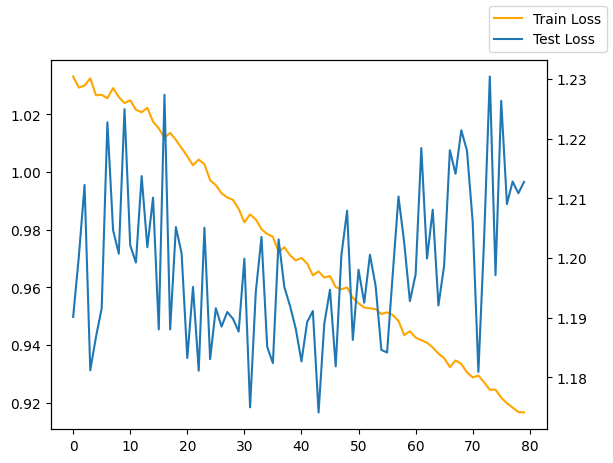

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

# Test

In [34]:
import matplotlib.pyplot as plt
import torch

In [38]:
sm_net = torch.load("./pretrained/attention.pth")

tensor([[3.0462],
        [2.9319],
        [4.2519],
        ...,
        [3.4630],
        [4.1942],
        [3.6928]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       865
           1       0.68      0.77      0.72      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000

tensor([[3.0462],
        [2.9319],
        [4.2519],
        ...,
        [3.4630],
        [4.1942],
        [3.6928]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       865
           1       0.69      0.74      0.71      1135

    accuracy                           0.66      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000

tensor([[3.0462],
        [2.9319],
        [4.2519],
        ...,
 

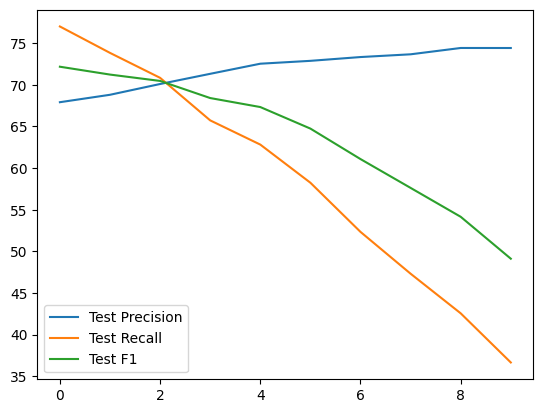

In [40]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)
    
plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()